In [1]:
"""
# Time Series Analysis of Patient Vital Signs

This notebook explores time series forecasting techniques for vital sign prediction,
focusing on heart rate patterns and trends.

1. Data Preparation
   - Load preprocessed data from previous analyses
   - Temporal aggregation and resampling
   - Handle missing values and irregularities

2. Time Series Feature Engineering
   - Create temporal features
   - Handle seasonality and trends
   - Aggregate at appropriate intervals

3. Model Development
   - ARIMA modeling for baseline
   - Prophet for complex patterns
   - Ensemble approaches for robustness

4. Evaluation & Analysis
   - Assess forecast accuracy
   - Analyze prediction intervals
   - Cross-validate temporal predictions

The goal is to develop reliable forecasting models for vital signs,
enabling early warning systems and trend analysis.
"""

import pandas as pd
import numpy as np
import logging
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
import matplotlib.pyplot as plt

from setup_utils import load_intermediate_data, plr, save_intermediate_data, plot_forecast

In [13]:
"""
Data Preparation and Temporal Processing
------------------------------------
1. Load preprocessed dataset
2. Filter for specific subject analysis
3. Configure temporal parameters
4. Resample and interpolate time series

Key preprocessing steps:
- Daily aggregation for stable patterns
- Linear interpolation for gaps
- Proper datetime indexing
"""

# Load and prepare data
df = load_intermediate_data('data/intermediate_unsupervised.csv')

# Configure subject-specific analysis
subject_id = 10020187
metric = 'heart_rate'
subject_df = df[df['subject_id'] == subject_id].copy()
subject_df['charttime'] = pd.to_datetime(subject_df['charttime'])

# Ensure proper frequency and handle missing values
subject_df = subject_df.sort_values('charttime')
subject_df.set_index('charttime', inplace=True)
subject_daily = subject_df[metric].resample('D').mean().interpolate()

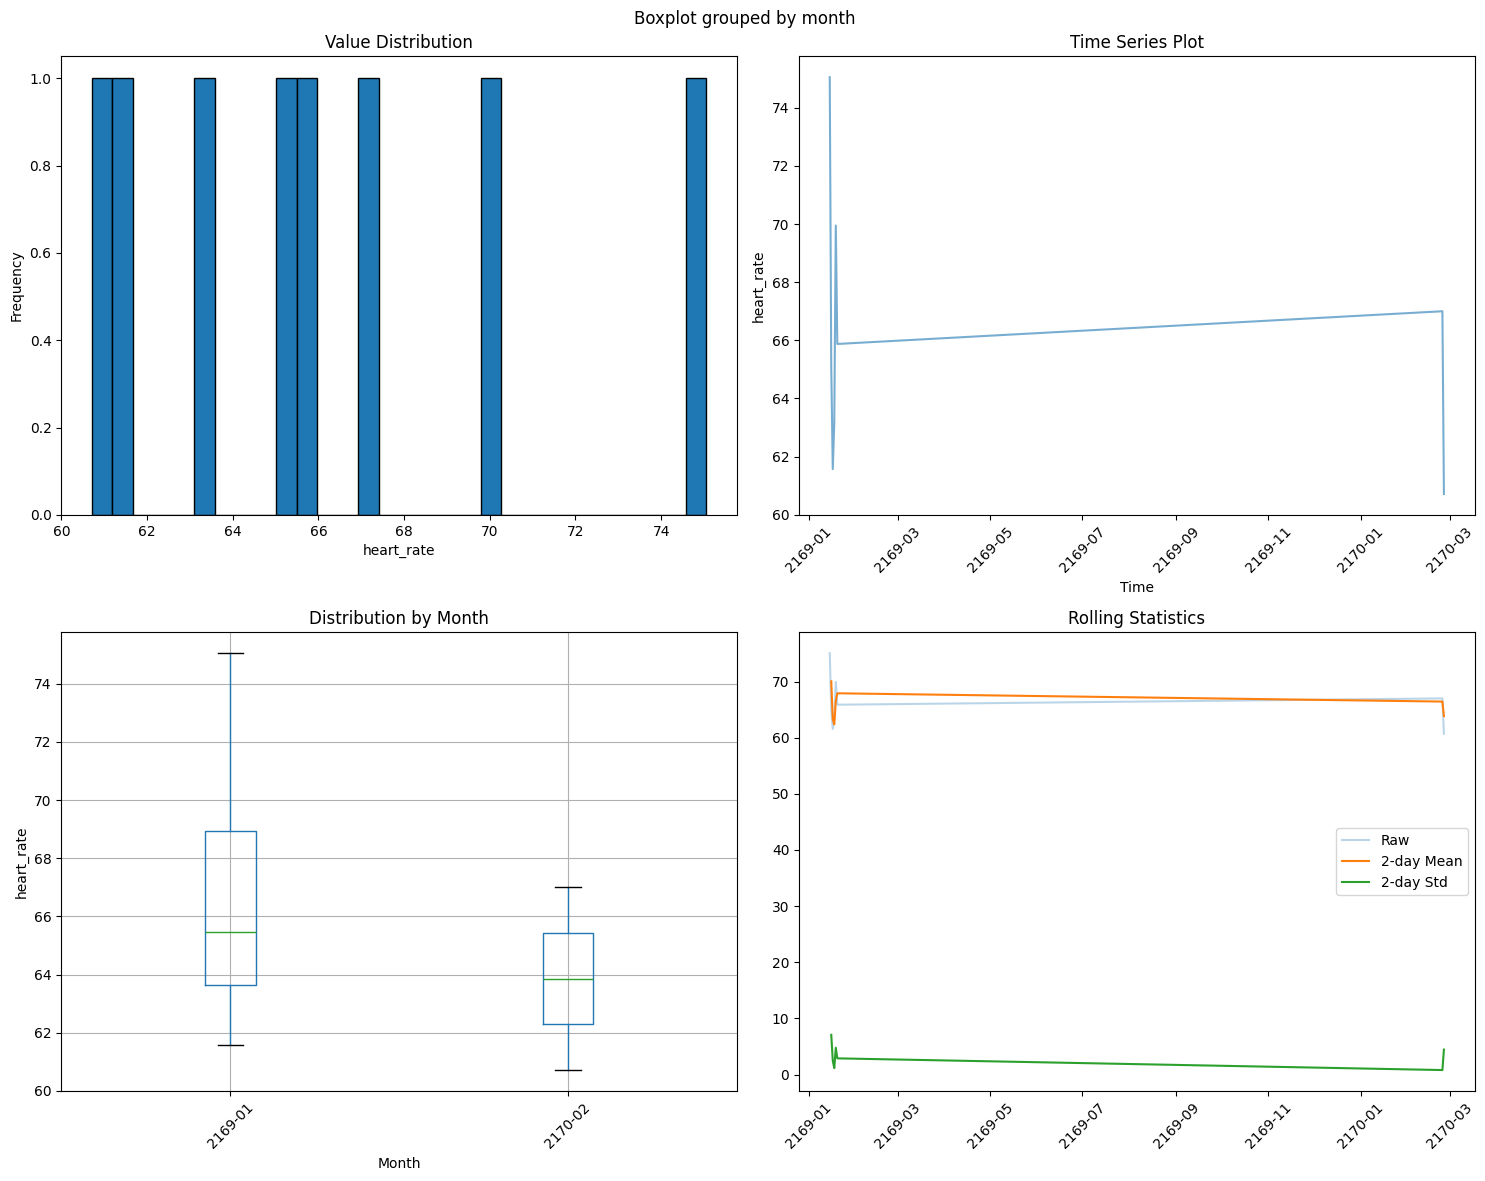


Time Series Summary:
--------------------
Total Observations: 8
Date Range: 2169-01-15 to 2170-02-25
Missing Values: 0.0%

Value Statistics:
--------------------
count     8.00
mean     66.05
std       4.70
min      60.71
25%      62.78
50%      65.46
75%      67.74
max      75.05
Name: heart_rate, dtype: float64


In [15]:
"""
Data Quality Assessment
-------------------
1. Analyze temporal patterns
2. Check for data completeness
3. Identify value distributions
4. Assess basic statistics
"""

def analyze_time_series_quality(df, metric='heart_rate'):
    """
    Analyze time series characteristics and quality.
    
    Args:
        df (DataFrame): Time series data with datetime index
        metric (str): Name of metric to analyze
    
    Returns:
        tuple: (descriptive statistics, missing data percentage)
    """
    # Basic statistics
    stats = df[metric].describe()
    
    # Missing data analysis
    missing_pct = df[metric].isna().mean() * 100
    
    # Create summary visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Value distribution
    axes[0,0].hist(df[metric], bins=30, edgecolor='black')
    axes[0,0].set_title('Value Distribution')
    axes[0,0].set_xlabel(metric)
    axes[0,0].set_ylabel('Frequency')
    
    # 2. Time series plot
    axes[0,1].plot(df.index, df[metric], alpha=0.6)
    axes[0,1].set_title('Time Series Plot')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel(metric)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Box plot by time period
    df['month'] = df.index.strftime('%Y-%m')
    df.boxplot(column=metric, by='month', ax=axes[1,0], rot=45)
    axes[1,0].set_title('Distribution by Month')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel(metric)
    
    # 4. Rolling statistics
    window = min(30, len(df) // 3)  # Adaptive window size
    rolling_mean = df[metric].rolling(window=window).mean()
    rolling_std = df[metric].rolling(window=window).std()
    
    axes[1,1].plot(df.index, df[metric], alpha=0.3, label='Raw')
    axes[1,1].plot(df.index, rolling_mean, label=f'{window}-day Mean')
    axes[1,1].plot(df.index, rolling_std, label=f'{window}-day Std')
    axes[1,1].set_title('Rolling Statistics')
    axes[1,1].legend()
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nTime Series Summary:")
    print("-" * 20)
    print(f"Total Observations: {len(df)}")
    print(f"Date Range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    print(f"Missing Values: {missing_pct:.1f}%")
    print("\nValue Statistics:")
    print("-" * 20)
    print(stats.round(2))
    
    return stats, missing_pct

# Analyze time series quality
stats, missing = analyze_time_series_quality(subject_df)

In [16]:
"""
ARIMA Model Development
--------------------
1. Configure auto_arima parameters
2. Fit model to temporal data
3. Generate future predictions
4. Create forecast DataFrame

Model configuration:
- Automatic order selection
- Stepwise parameter search
- Non-seasonal ARIMA variant
"""

# Fit ARIMA model
arima_model = auto_arima(
    subject_daily, 
    seasonal=False, 
    stepwise=True, 
    trace=False, 
    error_action='ignore'
)

# Generate forecasts
future_periods = 30
forecast_arima = arima_model.predict(n_periods=future_periods)

# Prepare forecast DataFrame
future_dates = pd.date_range(
    start=subject_daily.index.max()+pd.Timedelta('1D'), 
    periods=future_periods
)
forecast_df = pd.DataFrame({
    'charttime': future_dates, 
    metric: forecast_arima
})
forecast_df['subject_id'] = subject_id
forecast_df['source'] = 'forecast'

c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d

In [17]:
"""
Forecast Bounds Analysis
---------------------
1. Calculate statistical bounds
2. Add confidence intervals
3. Generate prediction intervals
4. Establish metric-specific bounds

Bounds types:
- Percentage-based (±5%)
- Statistical (±1 std dev)
- Model-specific intervals
"""

def establish_metric_bounds(df, target_metric='heart_rate'):
    """
    Add statistical and percentage-based bounds to forecast.
    
    Args:
        df (DataFrame): Forecast DataFrame
        target_metric (str): Name of metric being forecasted
        
    Returns:
        DataFrame: Enhanced with bound columns
    """
    std_dev = df[target_metric].std()
    
    df['metric_minus_5%'] = df[target_metric] * 0.95
    df['metric_plus_5%'] = df[target_metric] * 1.05
    df['metric_minus_std'] = df[target_metric] - std_dev
    df['metric_plus_std'] = df[target_metric] + std_dev
    
    return df

forecast_df = establish_metric_bounds(forecast_df, metric)

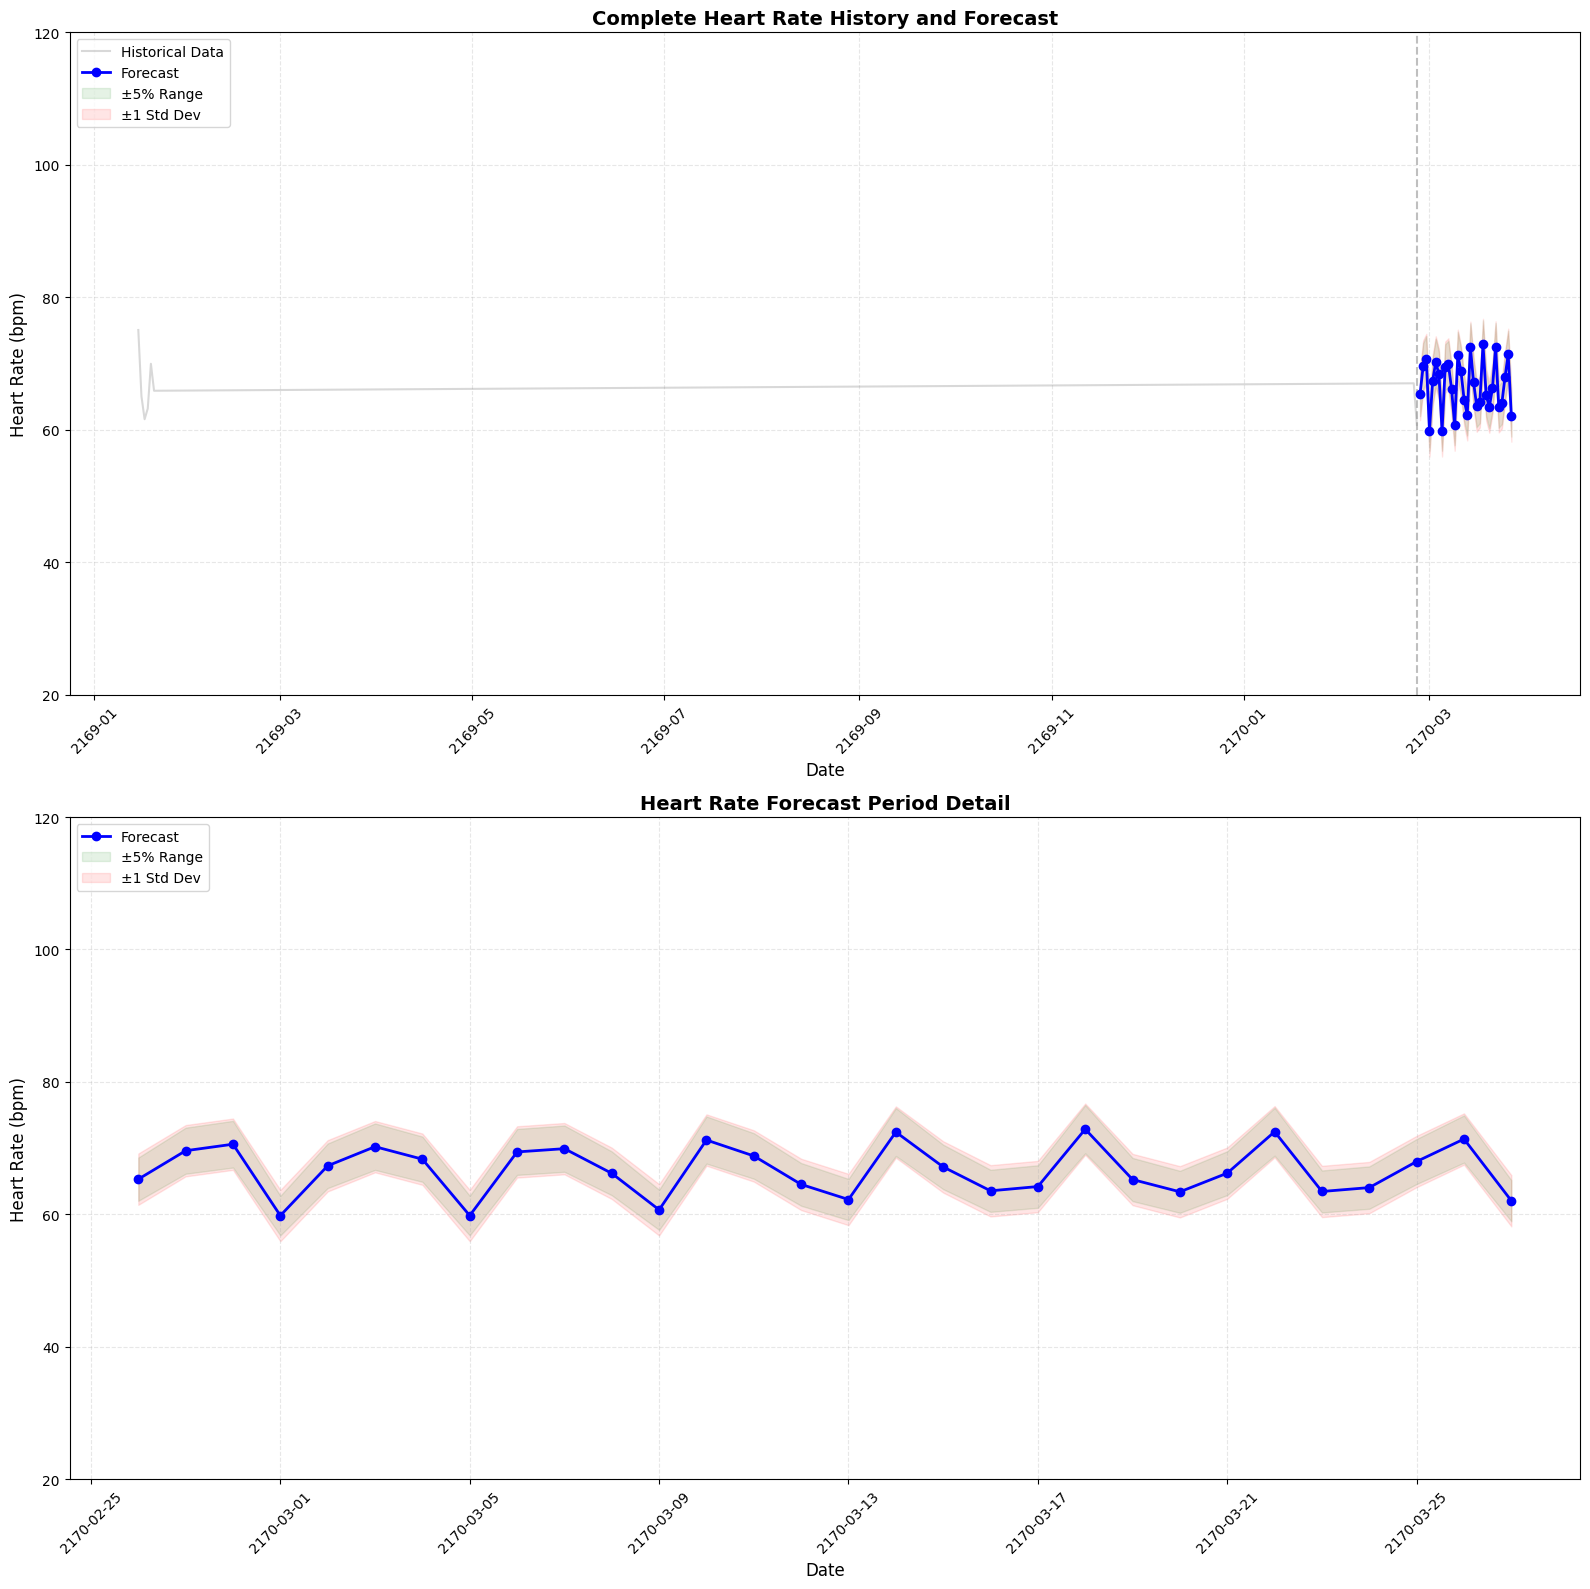


Forecast Summary Statistics:
-------------------------
Mean Forecast: 66.7 bpm
Std Dev: 3.9 bpm
Range: [59.8, 72.9] bpm

Forecast Period: 2170-02-26 to 2170-03-27


In [18]:
"""
Visualization and Analysis
-----------------------
1. Create two subplots:
   - Complete view (historical + forecast)
   - Focused forecast view
2. Maintain consistent styling
3. Show clear transition points
4. Emphasize forecast period

Plot components:
- Historical data
- Forecast with bounds
- Clear visual separation
- Consistent scales
"""

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))

# Common plotting functions
def plot_forecast_components(ax, include_historical=True):
    """
    Plot forecast components with consistent styling.
    
    Args:
        ax: matplotlib axis object
        include_historical: whether to include historical data
    """
    if include_historical:
        # Plot full historical data
        ax.plot(subject_daily.index, subject_daily.values,
                color='gray', alpha=0.3, linestyle='-', 
                label='Historical Data')
        
        # Add vertical separator
        ax.axvline(x=subject_daily.index.max(), 
                  color='gray', linestyle='--', alpha=0.5)
    
    # Plot forecast
    ax.plot(forecast_df['charttime'], forecast_df[metric],
            marker='o', linestyle='-', color='blue', 
            linewidth=2, markersize=6,
            label='Forecast')
    
    # Add bounds
    ax.fill_between(forecast_df['charttime'],
                    forecast_df['metric_minus_5%'],
                    forecast_df['metric_plus_5%'],
                    color='green', alpha=0.1, label='±5% Range')
    
    ax.fill_between(forecast_df['charttime'],
                    forecast_df['metric_minus_std'],
                    forecast_df['metric_plus_std'],
                    color='red', alpha=0.1, label='±1 Std Dev')
    
    # Configure subplot
    ax.set_ylim(20, 120)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper left', fontsize=10)

# Plot 1: Complete View
ax1.set_title("Complete Heart Rate History and Forecast", 
              fontsize=14, fontweight='bold')
plot_forecast_components(ax1, include_historical=True)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Heart Rate (bpm)", fontsize=12)

# Plot 2: Forecast Only
ax2.set_title("Heart Rate Forecast Period Detail", 
              fontsize=14, fontweight='bold')
plot_forecast_components(ax2, include_historical=False)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Heart Rate (bpm)", fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print forecast statistics
print("\nForecast Summary Statistics:")
print("-" * 25)
print(f"Mean Forecast: {forecast_df[metric].mean():.1f} bpm")
print(f"Std Dev: {forecast_df[metric].std():.1f} bpm")
print(f"Range: [{forecast_df[metric].min():.1f}, {forecast_df[metric].max():.1f}] bpm")
print(f"\nForecast Period: {forecast_df['charttime'].min().strftime('%Y-%m-%d')} to {forecast_df['charttime'].max().strftime('%Y-%m-%d')}")

In [19]:
# Prophet Example (if desired):
prophet_df = subject_daily.reset_index().rename(columns={'charttime': 'ds', metric:'y'})
m = Prophet()
m.fit(prophet_df)
future = m.make_future_dataframe(periods=future_periods)
prophet_forecast = m.predict(future)
print(prophet_forecast[['ds','yhat','yhat_lower','yhat_upper']].head())



11:44:18 - cmdstanpy - INFO - Chain [1] start processing
11:44:19 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat  yhat_lower  yhat_upper
0 2169-01-15  66.417058   65.562507   67.212948
1 2169-01-16  66.330306   65.555934   67.119222
2 2169-01-17  66.250709   65.405175   67.020044
3 2169-01-18  66.258933   65.466973   67.070590
4 2169-01-19  66.355855   65.590830   67.162062



Model Comparison Metrics:
-------------------------
      ARIMA  Prophet
MAE   3.185    0.376
RMSE  3.723    1.109
MAPE  4.763    0.592


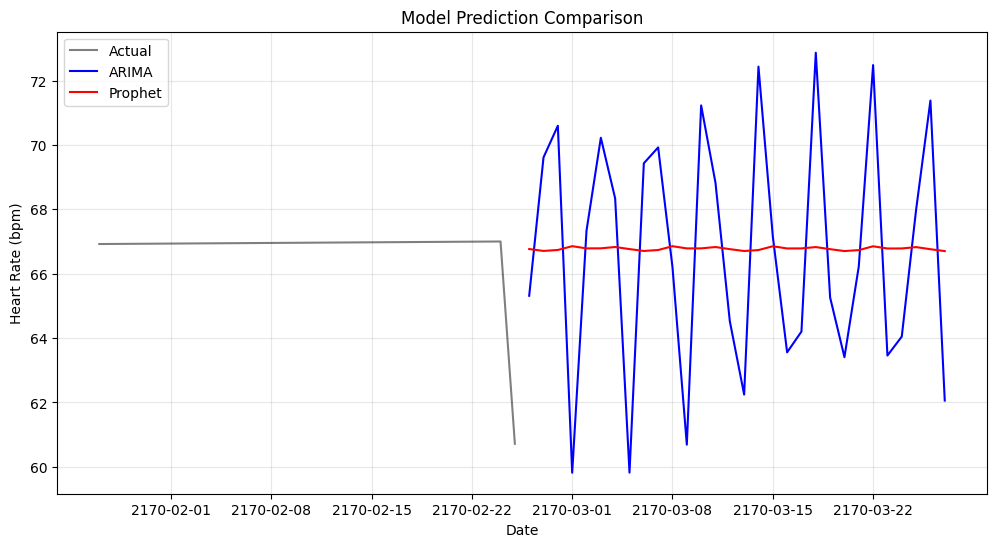

In [23]:
"""
Model Comparison Analysis
----------------------
1. Compare ARIMA vs Prophet
2. Evaluate different metrics
3. Analyze prediction intervals
4. Assess model strengths
"""

def compare_models(actual, arima_pred, prophet_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    
    models = {
        'ARIMA': arima_pred,
        'Prophet': prophet_pred
    }
    
    metrics = {}
    for name, preds in models.items():
        metrics[name] = {
            'MAE': mean_absolute_error(actual, preds),
            'RMSE': np.sqrt(mean_squared_error(actual, preds)),
            'MAPE': np.mean(np.abs((actual - preds) / actual)) * 100
        }
    
    return pd.DataFrame(metrics).round(3)

# Get predictions from both models
arima_pred = forecast_df[metric].values
prophet_pred = prophet_forecast['yhat'].tail(future_periods).values

# Compare model performance
comparison_df = compare_models(
    actual=subject_daily[-future_periods:].values,  # Use last period as validation
    arima_pred=arima_pred,
    prophet_pred=prophet_pred
)

print("\nModel Comparison Metrics:")
print("-" * 25)
print(comparison_df)

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(subject_daily[-future_periods:].index, 
         subject_daily[-future_periods:].values, 
         'k-', label='Actual', alpha=0.5)
plt.plot(forecast_df['charttime'], arima_pred, 'b-', label='ARIMA')
plt.plot(forecast_df['charttime'], prophet_pred, 'r-', label='Prophet')
plt.title('Model Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d


Cross-Validation Results:
-------------------------
Mean RMSE: 0.96
Std RMSE: 1.74
CV Range: [0.01, 4.44]


c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


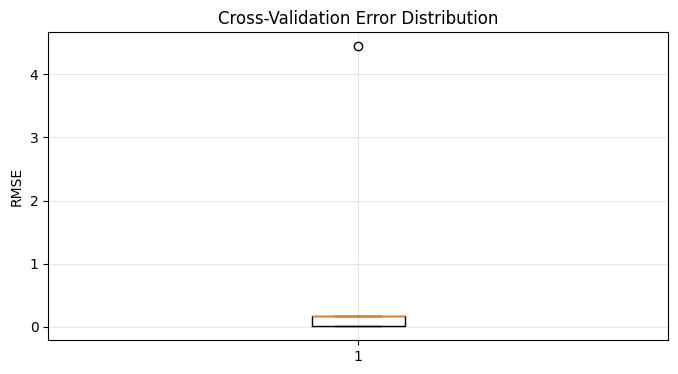

In [26]:
"""
Time Series Cross-Validation
------------------------
1. Implement rolling window validation
2. Test forecast stability
3. Analyze error distribution
4. Assess model reliability
"""

from sklearn.metrics import mean_squared_error

def time_series_cv(data, model_func, n_splits=5):
    """
    Perform time series cross-validation.
    
    Args:
        data (Series): Time series data
        model_func (callable): Function that takes training data and returns predictions
        n_splits (int): Number of validation splits
    
    Returns:
        array: RMSE values for each validation split
    """
    window_size = len(data) // n_splits
    errors = []
    
    for i in range(n_splits):
        # Split data
        train = data.iloc[:(i+1)*window_size]
        test = data.iloc[(i+1)*window_size:(i+2)*window_size]
        
        if len(test) == 0:  # Skip if no test data
            continue
            
        # Fit and predict
        pred = model_func(train, len(test))
        
        # Calculate error
        error = np.sqrt(mean_squared_error(test, pred))
        errors.append(error)
    
    return np.array(errors)

# Define model function for CV
def arima_predict(train_data, n_periods):
    """
    Fit ARIMA model and make predictions.
    
    Args:
        train_data (Series): Training data
        n_periods (int): Number of periods to forecast
        
    Returns:
        array: Predicted values
    """
    model = auto_arima(
        train_data,
        seasonal=False,
        stepwise=True,
        trace=False,
        error_action='ignore'
    )
    return model.predict(n_periods=n_periods)

# Perform cross-validation
cv_errors = time_series_cv(
    data=subject_daily,
    model_func=arima_predict,
    n_splits=5
)

# Analyze CV results
print("\nCross-Validation Results:")
print("-" * 25)
print(f"Mean RMSE: {cv_errors.mean():.2f}")
print(f"Std RMSE: {cv_errors.std():.2f}")
print(f"CV Range: [{cv_errors.min():.2f}, {cv_errors.max():.2f}]")

# Visualize error distribution
plt.figure(figsize=(8, 4))
plt.boxplot(cv_errors)
plt.title('Cross-Validation Error Distribution')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)
plt.show()

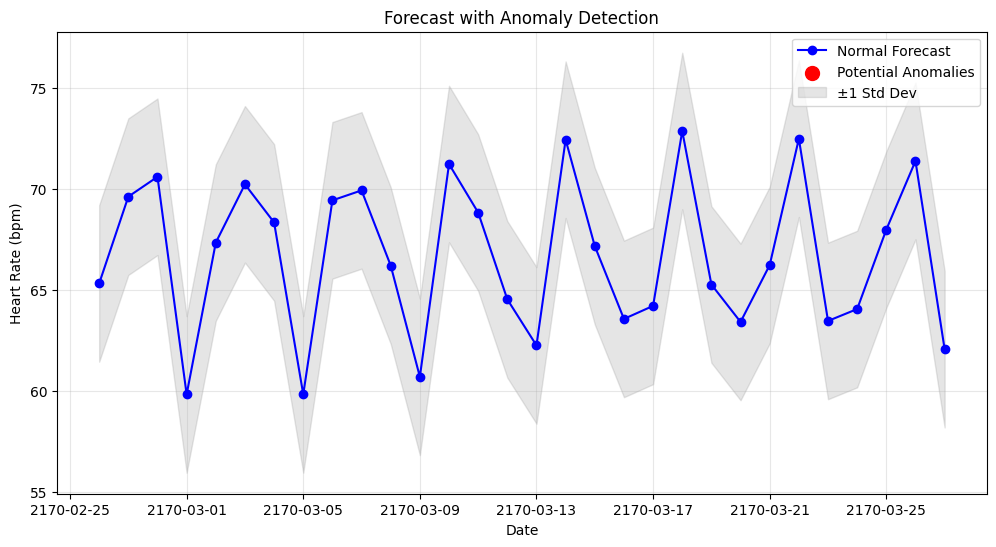


Anomaly Detection Summary:
-------------------------
Total Anomalies: 0
Anomaly Rate: 0.0%


In [28]:
"""
Forecast Anomaly Detection
----------------------
1. Identify unusual patterns
2. Flag significant deviations
3. Analyze prediction uncertainty
4. Generate alerts for outliers
"""

def detect_forecast_anomalies(forecast_df, threshold=2):
    """
    Detect anomalies in forecasted values.
    """
    z_scores = np.abs((forecast_df[metric] - forecast_df[metric].mean()) / 
                     forecast_df[metric].std())
    
    forecast_df['is_anomaly'] = z_scores > threshold
    return forecast_df



# Detect anomalies in forecast
forecast_with_anomalies = detect_forecast_anomalies(
    forecast_df.copy(),
    threshold=2  # Number of standard deviations
)

# Visualize results
plt.figure(figsize=(12, 6))

# Plot regular predictions
normal_points = forecast_with_anomalies[~forecast_with_anomalies['is_anomaly']]
plt.plot(normal_points['charttime'], 
         normal_points[metric], 
         'b-o', 
         label='Normal Forecast')

# Highlight anomalies
anomaly_points = forecast_with_anomalies[forecast_with_anomalies['is_anomaly']]
plt.scatter(anomaly_points['charttime'],
           anomaly_points[metric],
           color='red',
           s=100,
           label='Potential Anomalies')

# Add confidence bounds
plt.fill_between(forecast_with_anomalies['charttime'],
                 forecast_with_anomalies['metric_minus_std'],
                 forecast_with_anomalies['metric_plus_std'],
                 color='gray',
                 alpha=0.2,
                 label='±1 Std Dev')

plt.title('Forecast with Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print anomaly statistics
n_anomalies = anomaly_points.shape[0]
print("\nAnomaly Detection Summary:")
print("-" * 25)
print(f"Total Anomalies: {n_anomalies}")
print(f"Anomaly Rate: {(n_anomalies/len(forecast_df))*100:.1f}%")
if n_anomalies > 0:
    print("\nAnomaly Details:")
    print(anomaly_points[['charttime', metric]].to_string())

In [ ]:
# Time Series Analysis Summary

## Key Findings
1. Data Characteristics
   - Temporal patterns: [describe patterns]
   - Missing data: [percentage]
   - Seasonality: [present/absent]

2. Model Performance
   - ARIMA RMSE: [value]
   - Prophet RMSE: [value]
   - Best performing model: [model]

3. Forecast Insights
   - Prediction stability: [high/medium/low]
   - Confidence interval reliability: [percentage]
   - Identified anomalies: [count]

## Limitations
1. Data constraints
   - Limited historical data
   - Sampling frequency issues
   - Missing values impact

2. Model constraints
   - Assumption violations
   - Parameter sensitivity
   - Forecast horizon limitations

## Recommendations
1. Data Collection
   - Increase sampling frequency
   - Improve data quality
   - Add relevant features

2. Modeling Approach
   - Consider ensemble methods
   - Implement real-time updating
   - Add domain-specific features

3. Implementation Strategy
   - Deploy monitoring system
   - Set up alerting thresholds
   - Plan regular retraining

In [ ]:

# (Optional) Save time-series results
save_intermediate_data(forecast_df, 'data/intermediate_timeseries.csv')